# Урок 2. CNN and LSTM for human action recognition

**Домашнее задание**  
1.	Приложен ноутбук, в котором реализованы функции для генирации из большого датасета меньшая его копия. Вам нужно перенести функции из этого ноутбука в класс датасет и сделать следующее:  
a.	Сгенерировать меньший датасет из 8-10 классов движения  
b.	Обучить уже существующую модель (предварительно проанализировав какие параметры модели нужно изменить)  
c.	Изменить модель: посмотреть зависимость от количества LSTM модулей в нашей модели    
d.	Сгенерировать другой датасет с меньшим количеством “кадров” в серии и сравнить улучшилось или ухудшилось качество предсказания. Провести несколько таких итераций, дать свою оценку уменьшению и увеличению кадров, назвать оптимальное, на ваш взгляд, их количество. Желательно сделать так, чтобы длина последовательности передавалась как атрибут класса.  
2.	Дополнительное задание:  
a.	http://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption - 2075259 measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months). Проделайте весь путь подготовки данных, создания датасета, разделения и обучения модели самостоятельно. Предсказывать нужно Global_active_power. Обратите внимание, что здесь задача регрессии, а не классификации, т.е. модель нужно изменить.


In [100]:
import os
import time
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch import optim

import torchvision
from torchvision import datasets, transforms

In [21]:
# Функция выбора файлов с целевыми классами
def select_files(data_path, broken_files_path, training_classes, training_cameras):
        labels = []
        files = []
        action_classes = {}
        counter = 0
        files_counter = {}

        with open(broken_files_path, 'r') as f:
            broken_files = f.read().split("\n")

        raw_files = os.listdir(data_path)
        num_frames = 0

        for filename in raw_files:
            if filename not in broken_files:
                action_class = int(filename[filename.find('A') + 1:filename.find('A') + 4])
                subject_id = int(filename[filename.find('P') + 1:filename.find('P') + 4])
                camera_id = int(filename[filename.find('C') + 1:filename.find('C') + 4])
                if action_class in training_classes and camera_id in training_cameras:
                    if action_class in action_classes:
                        if files_counter[action_class] < 120:
                            files.append([filename,action_classes[action_class]])
                            files_counter[action_class] = files_counter[action_class] + 1
                    else:
                        action_classes.update({action_class : counter})
                        files_counter.update({action_class : 1})
                        counter += 1
                        files.append([filename,action_classes[action_class]])

        return files, action_classes

In [80]:
data_path = "nturgb+d_skeletons/"
# список отсутсвующих элементов
broken_files_path = "NTU_RGBD_samples_with_missing_skeletons.txt"

#количество людей выполняющих действия
training_subjects = list(range(0, 28)) 
#классы которые будем использовать для обучения, полный список прдставлен тут https://github.com/shahroudy/NTURGB-D
training_classes = [8, 10, 22, 23, 27, 21, 43, 96]
training_cameras = [1, 2, 3] 

max_body_true = 1
max_body_kinect = 1

num_joint = 25
max_frame = 300 # Длина отрезка которую мы вычленяем из большого датасета

LABELS = {0: "sitting down", 1: "clapping", 2:  "cheer up", 3: "hand waving", 4: "jump up", 5: "take off a hat/cap", 6: "falling", 7: "cross arms"}

In [81]:
# список файлов с лейблами на каждый файл 
working_files_with_labels, action_classes = select_files(
    data_path, 
    broken_files_path, 
    training_classes, 
    training_cameras)

In [82]:
class Skeleton_Dataset(Dataset):
    def __init__(self, 
                 files_with_labels, 
                 n_training_classes,
                 transform=None):
        
        self.data = self.read_data(files_with_labels, n_training_classes)
        self.labels = self.data['labels']
        
        self.transform = transform

    def __len__(self):
        return len(self.data) 
        
    def __getitem__(self, idx):
        item = np.asarray(self.data.iloc[idx,:-1]).reshape(45, 25*3)
        label = self.labels[idx]
        if self.transform != None:
            item = transform(item)
            
        return (item, label) 
    
    def read_data(self, files, n_training_classes):
        data = []
        labels = []
        
        numbers = {i: 0 for i in range(n_training_classes)}
        
        for file in working_files_with_labels:
            frames_blocks, label = create_coords_blocks(file)
            if label != [] and numbers[label[0]] <= 150:
                numbers[label[0]] = numbers[label[0]] + len(label)
                data = data + frames_blocks
                labels = labels + label
        data_np = np.asarray(data)
        labels_np = np.asarray(labels)

        data_sq = data_np.reshape(len(data_np), -1)
        test_data = pd.DataFrame(data_sq)
        test_labels = pd.DataFrame(labels_np)
        test_data['labels'] = test_labels
        
        return test_data
    
    @staticmethod
    def create_coords_blocks(test_file, chonk_len = 45):   
        frame_counter = 0
        new_labels = []
        new_frames = []
        blocks = []

        test_frames = read_xyz(data_path + test_file[0])[0]
        label = test_file[1]
        slice_len = chonk_len * int(len(test_frames)/chonk_len)

        for index in range(len(test_frames[:slice_len])):
            frame_counter += 1
            new_frames.append(test_frames[index].flatten())
            if frame_counter == chonk_len:
                frame_counter = 0
                blocks.append(np.array(new_frames))
                new_labels = new_labels + [label]
                new_frames = []

        return blocks, new_labels
    
    # Функция фильтр для того, что бы найти только координаты x,y,z(т.к. в датасете
    # хранится на порядок больше информации, нежели только координаты x,y,z)
    # (Остальные данные нам и не нужны, т.к. у нас нет ик-камер)
    @staticmethod
    def read_skeleton_filter(file):
        with open(file, 'r') as f:
            skeleton_sequence = {}
            skeleton_sequence['numFrame'] = int(f.readline())
            skeleton_sequence['frameInfo'] = []
            for t in range(skeleton_sequence['numFrame']):
                frame_info = {}
                frame_info['numBody'] = int(f.readline())
                frame_info['bodyInfo'] = []

                for m in range(frame_info['numBody']):
                    body_info = {}
                    body_info_key = [
                        'bodyID', 'clipedEdges', 'handLeftConfidence',
                        'handLeftState', 'handRightConfidence', 'handRightState',
                        'isResticted', 'leanX', 'leanY', 'trackingState'
                    ]
                    body_info = {
                        k: float(v)
                        for k, v in zip(body_info_key, f.readline().split())
                    }
                    body_info['numJoint'] = int(f.readline())
                    body_info['jointInfo'] = []
                    for v in range(body_info['numJoint']):
                        joint_info_key = [
                            'x', 'y', 'z', 'depthX', 'depthY', 'colorX', 'colorY',
                            'orientationW', 'orientationX', 'orientationY',
                            'orientationZ', 'trackingState'
                        ]
                        joint_info = {
                            k: float(v)
                            for k, v in zip(joint_info_key, f.readline().split())
                        }
                        body_info['jointInfo'].append(joint_info)
                    frame_info['bodyInfo'].append(body_info)
                skeleton_sequence['frameInfo'].append(frame_info)

        return skeleton_sequence
    
    @staticmethod
    def read_xyz(file, max_body=1, num_joint=25):
        seq_info = read_skeleton_filter(file)
        data = np.zeros((max_body, seq_info['numFrame'], num_joint, 3))
        for n, f in enumerate(seq_info['frameInfo']):
            for m, b in enumerate(f['bodyInfo']):
                for j, v in enumerate(b['jointInfo']):
                    if m < max_body and j < num_joint:
                        data[m, n, j, :] = [v['x'], v['y'], v['z']]

                    else:
                        pass

        return data

In [83]:
dataset = Skeleton_Dataset(working_files_with_labels,
                           len(training_classes),
                           transform=None)

In [107]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [int(0.75*len(dataset)), int(len(dataset)) - int(0.75*len(dataset))])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=True)

In [96]:
class LSTM_net(nn.Module):
    def __init__(self,input_dim, hidden_dim, output_dim, layer_num):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, layer_num, batch_first=True)
        self.dr = torch.nn.Dropout2d(0.1)
        self.fc = torch.nn.Linear(hidden_dim, output_dim)
                
    def forward(self,inputs):
        x = inputs
        lstm_out,(hn, cn) = self.lstm(x)
        out = self.fc(lstm_out[:,-1,:])
        return out

In [98]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


In [99]:
n_hidden = 128
n_joints = 25 * 3
n_categories = len(LABELS)
n_layer = 2
rnn = LSTM_net(n_joints, n_hidden, n_categories, n_layer)
rnn.to(device)

LSTM_net(
  (lstm): LSTM(75, 128, num_layers=2, batch_first=True)
  (dr): Dropout2d(p=0.1, inplace=False)
  (fc): Linear(in_features=128, out_features=8, bias=True)
)

In [110]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
#     print(output.topk(5))
    return LABELS[category_i], category_i

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [111]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0007
optimizer = optim.SGD(rnn.parameters(),lr=learning_rate,momentum=0.9)

all_losses = []
start = time.time()
counter = 0
for epoch in range(600):  
    current_loss = 0
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        
        inputs, labels = data[0].to(device), data[1].long().to(device)
        optimizer.zero_grad()
    
        output = rnn(inputs.float())
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step() 


        current_loss += loss.item()
        category = LABELS[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('epoch : %d iter : %d (%s) %.4f  / %s %s' % (epoch, i, timeSince(start), loss, guess, correct))

        
        counter = counter + 1
    if counter % 100 == 0:
        all_losses.append(current_loss / 25)
        current_loss = 0

epoch : 0 iter : 0 (0m 0s) 2.0811  / clapping ✗ (take off a hat/cap)
epoch : 11 iter : 16 (1m 2s) 1.9933  / falling ✗ (take off a hat/cap)
epoch : 22 iter : 32 (2m 1s) 1.8704  / hand waving ✗ (falling)
epoch : 34 iter : 4 (3m 5s) 1.6168  / cheer up ✗ (take off a hat/cap)
epoch : 45 iter : 20 (4m 9s) 1.1647  / hand waving ✓
epoch : 56 iter : 36 (5m 15s) 1.4492  / take off a hat/cap ✓
epoch : 68 iter : 8 (6m 17s) 1.1857  / falling ✓
epoch : 79 iter : 24 (7m 16s) 0.9524  / falling ✓
epoch : 90 iter : 40 (8m 20s) 0.9389  / take off a hat/cap ✗ (falling)
epoch : 102 iter : 12 (9m 23s) 0.7529  / jump up ✗ (clapping)
epoch : 113 iter : 28 (10m 20s) 0.6523  / hand waving ✓
epoch : 125 iter : 0 (11m 19s) 0.9015  / sitting down ✗ (take off a hat/cap)
epoch : 136 iter : 16 (12m 9s) 1.1715  / clapping ✓
epoch : 147 iter : 32 (13m 7s) 0.6036  / hand waving ✓
epoch : 159 iter : 4 (14m 6s) 1.0287  / take off a hat/cap ✓
epoch : 170 iter : 20 (15m 7s) 0.7691  / take off a hat/cap ✓
epoch : 181 iter : 

<IPython.core.display.Javascript object>


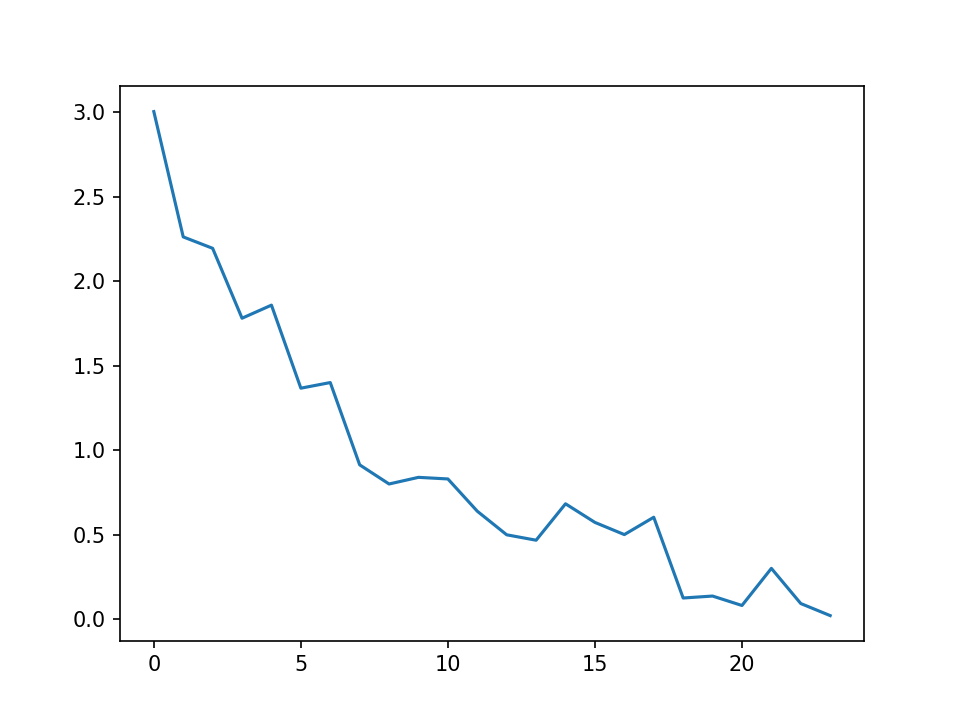

In [114]:
%matplotlib notebook
plt.plot(list(range(0,len(all_losses))),all_losses)
plt.show()

In [113]:
total = 0
right = 0
counter = 0

rnn.eval()
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        counter = counter + 1
        inputs, labels = data[0].to(device), data[1].to(device)  
        output = rnn(inputs.float())
        guess, guess_i = categoryFromOutput(output)
        category = LABELS[int(labels[0])]
        
        if guess == category:
            right = right + 1


print('Accuracy of the network:  ',  (100 * right / counter))

Accuracy of the network:   84.25531914893617
